In [5]:
from koala.pointsets import uniform
from koala import graph_utils as gu
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
import math
from koala.flux_finder import fluxes_from_ujk, ujk_from_fluxes
from koala.lattice import Lattice
from scipy import linalg as la

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
def _find_plaq(lat_list, starting_point, return_edges=False):
    """
    Finds a plaquette in a lattice given in planar code format, starting from a given point.

    Args:
        lat_list (list): The lattice represented as a list of numpy arrays, where each array contains the neighbors of a vertex, ordered clockwise.
        starting_point (tuple): The starting point of the plaquette, represented as a tuple (vertex, edge).
        return_edges (bool, optional): Whether to return the edges followed along the way -- useful for keeping track of which edges have been visited. Defaults to False.

    Returns:
        numpy.ndarray: An array of vertices that form the plaquette.
        numpy.ndarray (optional): An array of edges that form the plaquette, only returned if return_edges is True.
    """
    
    vertices = []
    edges = []
    current_vertex = starting_point[0]
    current_edge = starting_point[1]

    while True:
        # add vertex to the list
        vertices.append(current_vertex)
        edges.append(current_edge)

        # find the next vertex
        next_vertex = lat_list[current_vertex][current_edge]

        # find the next jump
        pos_on_next = np.where(lat_list[next_vertex] == current_vertex)[0][0]
        next_edge = (pos_on_next + 1) % len(lat_list[next_vertex])

        # check if we are back to the starting point
        if next_vertex == starting_point[0]:
            break

        # update the current vertex and edge
        current_vertex = next_vertex
        current_edge = next_edge

    if return_edges:
        return np.array(vertices), np.array(edges)
    return np.array(vertices)

def find_all_plaqs(lat_list):
    """
    Finds all plaquettes in a lattice given in planar code format.

    Args:
        lat_list (list): The lattice represented as a list of numpy arrays, where each array contains the neighbors of a vertex, ordered clockwise.

    Returns:
        list: A list of plaquettes found in the lattice, giving vertices that form each plaquette.
    """
    pos_tried = [p*0 for p in lat_list]
    plaqs = []
    for i in range(len(lat_list)):
        for j in range(len(lat_list[i])):
            if not pos_tried[i][j]:
                plaquette, edges = _find_plaq(lat_list, (i, j), return_edges=True)
                for p,e in zip(plaquette, edges):
                    pos_tried[p][e] = 1
                plaqs.append(plaquette)
    return plaqs

def read_plantri(filename, verbose=False):
    with open(filename, "rb") as f:
        output = np.fromfile(f, dtype=np.uint8)[15:]

    lattices = []
    output = np.split(output, np.where(output == 0)[0]+1)[:-1]
    output = [n[:-1] for n in output]

    while len(output)>0:
        number_of_points = output[0][0]
        output[0] = output[0][1:]    
        current_lattice = output[:number_of_points]
        output = output[number_of_points:]
        current_lattice = [p-1 for p in current_lattice]
        lattices.append(current_lattice)
    if verbose: print("Lattices found: ", len(lattices))

    return lattices

def tutte_embedding(lat_list):
    """
    Computes the Tutte embedding for a given lattice, given in planar code format.

    Args:
        lat_list (list): The lattice represented as a list of numpy arrays, where each array contains the neighbors of a vertex, ordered clockwise.

    Returns:
        numpy.ndarray: An array of positions representing the Tutte embedding.

    """
    # find largest plaquette
    plaqs = find_all_plaqs(lat_list)
    lengths = [len(p) for p in plaqs]
    plaquette_0 = plaqs[np.argmax(lengths)]

    # assign positions of largest plaquette
    n_verts = len(plaquette_0)
    angles = np.linspace(0, 2*math.pi, n_verts, endpoint=False)-math.pi/4
    plaquette_positions = np.array([np.cos(angles), np.sin(angles)]).T/2 
    maximum = np.max(np.abs(plaquette_positions))
    plaquette_positions = 0.475*plaquette_positions/maximum + 0.5

    scaled_adjacency = np.zeros((len(lat_list), len(lat_list)))
    for n,v in enumerate(lat_list):
        if n not in plaquette_0:
            scaled_adjacency[n, v] = 1/len(v)

    x_positions = np.zeros(len(lat_list))
    y_positions = np.zeros(len(lat_list))
    x_positions[plaquette_0] = plaquette_positions[:,0]
    y_positions[plaquette_0] = plaquette_positions[:,1]

    one = np.eye(len(lat_list))
    x_out = np.linalg.solve(one-scaled_adjacency, x_positions)
    y_out = np.linalg.solve(one-scaled_adjacency, y_positions)

    positions = np.array([x_out, y_out]).T
    return positions

def plantri_to_koala(lat_list):
    """
    Converts a plantri lattice representation to a Koala lattice representation.

    Args:
        lat_list (list): The lattice represented as a list of numpy arrays, where each array contains the neighbors of a vertex, ordered clockwise.

    Returns:
        Lattice: A Koala lattice object representing the converted lattice.
    """
    
    # tutte algorithm to embed the lattice
    vertex_positions = tutte_embedding(lat_list)

    # find all edges
    edges = [ np.sort(np.array([[n]*len(v2),v2]).T,axis =1) for n,v2 in enumerate(lat_list)]
    edges = np.concatenate(edges)
    edges = np.unique(edges, axis=0)

    lat_ko = Lattice(vertex_positions, edges, edges*0)
    return lat_ko


Lattices found:  185


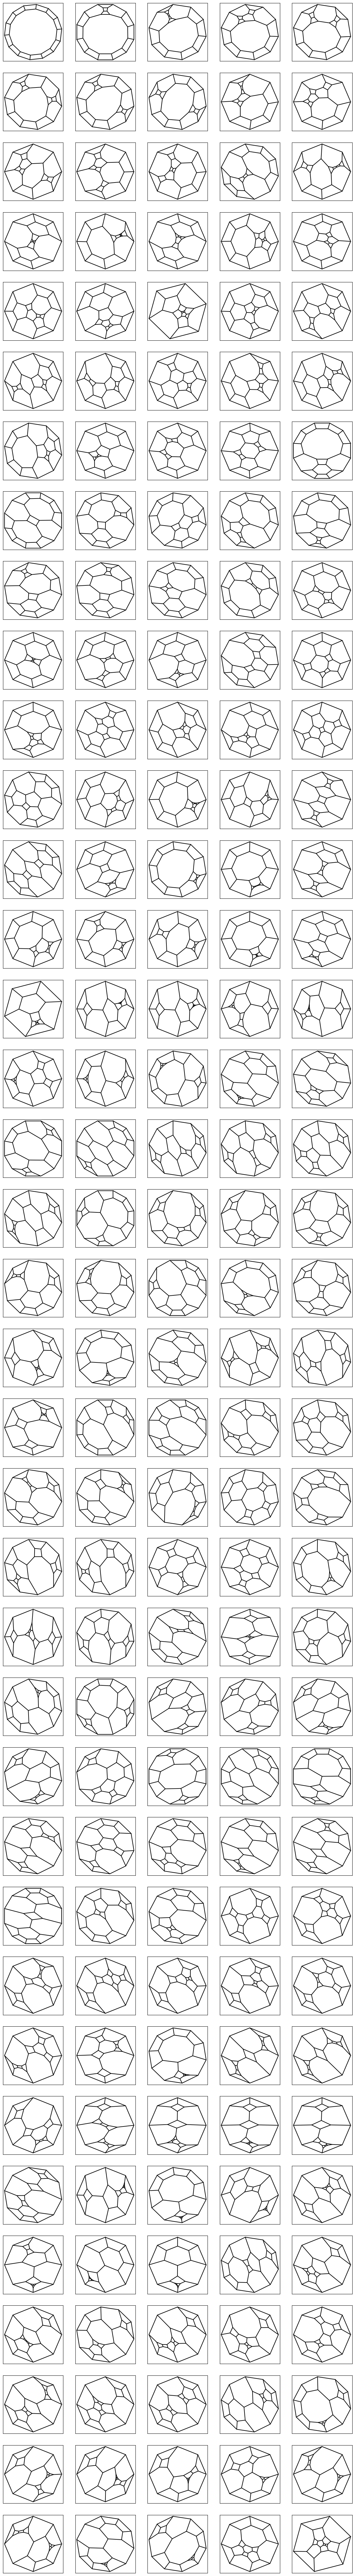

In [10]:

lat_list_s = read_plantri("outL.txt", verbose=True)
n_lattices = len(lat_list_s)

# we will now plot the lattices
fig, axes = plt.subplots(math.ceil(n_lattices/5),5, figsize=(15,3*n_lattices//5), dpi = 100)
axes = axes.flatten()

# now for each lattice we find a plaquette
for n,lat in enumerate(lat_list_s):
    lat_ko = plantri_to_koala(lat)

    pl.plot_edges(lat_ko, color='black', ax = axes[n])
    axes[n].set_xticks([])
    axes[n].set_yticks([])


In [8]:

# x = np.array(list(lines))
# with np.printoptions(threshold=np.inf):
#     print(x)

# def adjacencies_from_plantri(output):
#     pass

# parse_plantri_output(x)
